In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from itertools import combinations_with_replacement

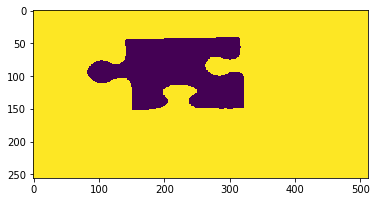

In [2]:
img = cv2.imread("RP2_cropped3.jpg", cv2.IMREAD_COLOR)
img =cv2.resize(img  , (512, 256))
#plt.imshow(img)
gray = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
blurred_frame = cv2.GaussianBlur(gray, (5, 5), 0)
ret,thresh = cv2.threshold(blurred_frame,127,255,cv2.THRESH_BINARY)
plt.imshow(thresh)
#hsv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2HSV)


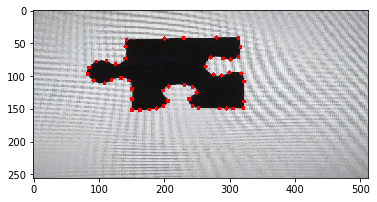

[[151, 152], [321, 149], [142, 45], [314, 42], [134, 103], [206, 138], [126, 82], [301, 75], [317, 56], [151, 135], [243, 146], [238, 135], [249, 125], [198, 122], [120, 106], [318, 96], [271, 72], [314, 71], [163, 152], [177, 151], [305, 150], [295, 150], [284, 150], [188, 150], [253, 149], [322, 139], [151, 120], [243, 117], [207, 116], [231, 114], [109, 111], [322, 108], [288, 99], [275, 98], [83, 97], [300, 95], [263, 86], [96, 78], [112, 77], [290, 73], [140, 73], [141, 55], [200, 43], [229, 42], [280, 41], [146, 107], [199, 146], [92, 107], [85, 87]]
49
[[ 83 153]
 [ 82  43]
 [321  40]
 [322 149]]


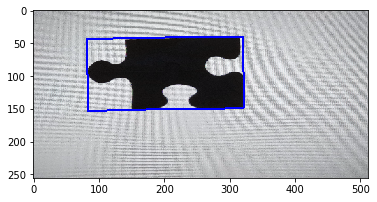

In [3]:
corners = cv2.goodFeaturesToTrack(thresh,75,0.01,10)
corners = np.int0(corners)
#print(corners)
corners_list=[]
img_with_corners = img.copy()
#print(corners.ravel())
for i in corners:
    x,y = i.ravel()
    corners_list.append([x,y])
    img_with_corners = cv2.circle(img_with_corners,(x,y),3,255,-1)
plt.imshow(img_with_corners),plt.show()
cv2.namedWindow('corners', cv2.WINDOW_NORMAL)
cv2.imshow('corners', img_with_corners)
plt.imshow(img_with_corners)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
print(corners_list)
print(len(corners_list))
rect = cv2.minAreaRect(corners)
box = cv2.boxPoints(rect)
box = np.int0(box)
img_with_box = img.copy()
img_with_box = cv2.drawContours(img_with_box,[box],0,(0,0,255),2)
print(box)
cv2.namedWindow("img_with_box" , cv2.WINDOW_NORMAL)
cv2.imshow("img_with_box", img_with_box)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
plt.imshow(img_with_box)

202
96
(202, 96)


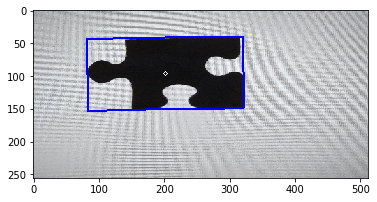

In [4]:
#Finding the center point of the rectangle
center_x =int((box[1][0] + box[3][0])/2)
center_y =int((box[1][1] + box[3][1])/2)
print(center_x)
print(center_y)
img_center = cv2.circle(img_with_box, (center_x, center_y) , 3, (255,255,255),1)
plt.imshow(img_center)
tile_center= (center_x , center_y)
tile_center = tuple(np.round(tile_center).astype(np.int))
print(tile_center)

In [5]:
def get_vector(p1, p2):
    if type(p1).__module__ != np.__name__:
        p1 = np.array(p1)
    if type(p2).__module__ != np.__name__:
        p2 = np.array(p2)
    return p2 - p1

In [6]:
def get_angle(p1,p2,p3):
    """calculate angle between p2_p3 and p2_p3"""
    p2p1 = get_vector(p2,p1)
    p2p3 = get_vector(p2,p3)
    cosine_angle = np.dot(p2p1, p2p3) / (np.linalg.norm(p2p1) * np.linalg.norm(p2p3))
    angle = np.arccos(cosine_angle)
    #print(np.degrees(angle))
    return np.degrees(angle)

In [7]:
#new =[]
angle_margin = 30
corners=corners_list
corner_left_top_candidates=[]
corner_left_bottom_candidates=[]
angle_candidates_left_top =[]
angle_candidates_left_bottom =[]
#print(corners)
margin =30
def corners_new_left():
    for c1 in corners:
        #print(c1) 
        if c1[0] <= tile_center[0] and c1[1] <= tile_center[1]:
            corner_left_top_candidates.append(c1)
    #print(corner_left_top_candidates)
    corner_left_top_candidates_sorted = sorted(corner_left_top_candidates, key=lambda x: x[0])
    #print(corner_left_top_candidates_sorted)
    for i in range(len(corner_left_top_candidates_sorted)-2):
        a = get_angle(corner_left_top_candidates_sorted[i],corner_left_top_candidates_sorted[i+1],corner_left_top_candidates_sorted[i+2])
        #del corner_left_top_candidates_sorted[0]
        if 90 - margin < a < 90 + margin:
            angle_candidates_left_top.append(corner_left_top_candidates_sorted[i+1])
    
    
    for c1 in corners:
        #print(c1) 
        if c1[0] <= tile_center[0] and c1[1] >= tile_center[1]:
            corner_left_bottom_candidates.append(c1)
   # print(corner_left_bottom_candidates)
    corner_left_bottom_candidates_sorted = sorted(corner_left_bottom_candidates, key=lambda x: x[0])
    #print(corner_left_bottom_candidates_sorted)
    for i in range(len(corner_left_bottom_candidates_sorted)-2):
        a = get_angle(corner_left_bottom_candidates_sorted[i],corner_left_bottom_candidates_sorted[i+1],corner_left_bottom_candidates_sorted[i+2])
        #del corner_left_top_candidates_sorted[0]
        if 90 - margin < a < 90 + margin:
            angle_candidates_left_bottom.append(corner_left_bottom_candidates_sorted[i+1])
            
    #print(angle_candidates)
    #corner_left_top_candidates_combination = list(combinations_with_replacement(corner_left_top_candidates, 2)) 
    #print(corner_left_top_candidates_combination)
    
    
    return angle_candidates_left_top ,angle_candidates_left_bottom
    

In [8]:
angle_margin = 5
corners=corners_list
corner_right_top_candidates=[]
corner_right_bottom_candidates=[]
angle_candidates_right_top =[]
angle_candidates_right_bottom =[]
def corners_new_right():
    for c1 in corners:
        #print(c1) 
        if c1[0] >= tile_center[0] and c1[1] <= tile_center[1]:
            corner_right_top_candidates.append(c1)
    #print(corner_right_top_candidates)
    corner_right_top_candidates_sorted = sorted(corner_right_top_candidates, key=lambda x: x[0])
    #print(corner_right_top_candidates_sorted)
    for i in range(len(corner_right_top_candidates_sorted)-2):
        a = get_angle(corner_right_top_candidates_sorted[i],corner_right_top_candidates_sorted[i+1],corner_right_top_candidates_sorted[i+2])
        #del corner_left_top_candidates_sorted[0]
        if 90 - margin < a < 90 + margin:
            angle_candidates_right_top.append(corner_right_top_candidates_sorted[i+1])
    
    
    for c1 in corners:
        #print(c1) 
        if c1[0] >= tile_center[0] and c1[1] >= tile_center[1]:
            corner_right_bottom_candidates.append(c1)
    #print(corner_right_bottom_candidates)
    corner_right_bottom_candidates_sorted = sorted(corner_right_bottom_candidates, key=lambda x: x[0])
    #print(corner_right_bottom_candidates_sorted)
    for i in range(len(corner_right_bottom_candidates_sorted)-2):
        a = get_angle(corner_right_bottom_candidates_sorted[i],corner_right_bottom_candidates_sorted[i+1],corner_right_bottom_candidates_sorted[i+2])
        #del corner_left_top_candidates_sorted[0]
        if 90 - margin < a < 90 + margin:
            angle_candidates_right_bottom.append(corner_right_bottom_candidates_sorted[i+1])
            
    #print(angle_candidates)
    #corner_left_top_candidates_combination = list(combinations_with_replacement(corner_left_top_candidates, 2)) 
    #print(corner_left_top_candidates_combination)
    
    
    return angle_candidates_right_top ,angle_candidates_right_bottom

[[142, 45]]
[[146, 107], [163, 152], [188, 150]]


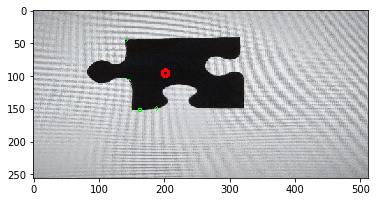

In [9]:
angle_candidates_left_top ,angle_candidates_left_bottom = corners_new_left()
print(angle_candidates_left_top)
print(angle_candidates_left_bottom)
for i in angle_candidates_left_top:
    img_candidates_left = cv2.circle(img, tuple(i), 3 , (0,255,0), 1)
for i in angle_candidates_left_bottom:
    img_candidates_left = cv2.circle(img, tuple(i), 3 , (0,255,0), 1)
cv2.circle(img_candidates_left, (tile_center[0] , tile_center[1]), 5 , (255,0,0), 3)   
plt.imshow(img_candidates_left)

[[142, 45]]
[[146, 107], [163, 152], [188, 150]]


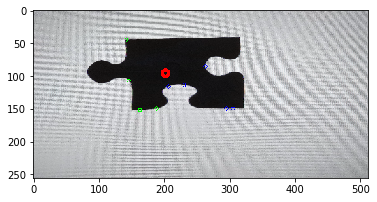

In [10]:
angle_candidates_right_top ,angle_candidates_right_bottom = corners_new_right()
print(angle_candidates_left_top)
print(angle_candidates_left_bottom)
for i in angle_candidates_right_top:
    img_candidates_right = cv2.circle(img, tuple(i), 3 , (0,0,255), 1)
for i in angle_candidates_right_bottom:
    img_candidates_left = cv2.circle(img, tuple(i), 3 , (0,0,255), 1)
#cv2.circle(img_candidates_right, (tile_center[0] , tile_center[1]), 5 , (255,0,0), 3)   
plt.imshow(img_candidates_right)

130305.0
18111.5
[array([[[0, 0]],

       [[0, 1]],

       [[0, 2]],

       ...,

       [[3, 0]],

       [[2, 0]],

       [[1, 0]]], dtype=int32), array([[[279,  41]],

       [[280,  40]],

       [[281,  40]],

       ...,

       [[276,  41]],

       [[277,  41]],

       [[278,  41]]], dtype=int32)]


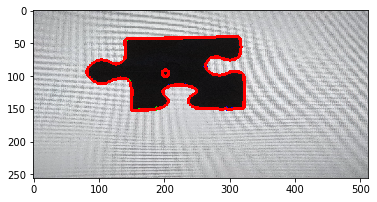

In [11]:
_, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_with_contours= img.copy()
for contour in contours:
    area = cv2.contourArea(contour)
    print(area)
    if   (area  < 60000):
        #contour_final.append(contour)
        cv2.drawContours(img_with_contours, contour, -1, (255, 0, 0), 3)
print(contours)
plt.imshow(img_with_contours)

In [12]:
left_top_corner_point=[]
left_bottom_corner_point=[]
right_top_corner_point =[]
right_bottom_corner_point =[]
print(len(angle_candidates_left_top))
#rint(angle_candidates_left_top[1][0])
b = []
for i in range(0, len(angle_candidates_left_top)):
    b.append(angle_candidates_left_top[i][0])
#rint(b)

d = b.index(min(b))
#rint(d)
left_top_corner_point.append(angle_candidates_left_top[d])
print(left_top_corner_point)
b=[]
for i in range(0, len(angle_candidates_left_bottom)):
    b.append(angle_candidates_left_bottom[i][1])
#rint(b)    
d = b.index(max(b))
#rint(d)
left_bottom_corner_point.append(angle_candidates_left_bottom[d])
print(left_bottom_corner_point)

b=[]
for i in range(0, len(angle_candidates_right_top)):
    b.append(angle_candidates_right_top[i][0])
#rint(b)    
d = b.index(max(b))
#rint(d)
right_top_corner_point.append(angle_candidates_right_top[d])
print(right_top_corner_point)


b=[]
for i in range(0, len(angle_candidates_right_bottom)):
    b.append(angle_candidates_right_bottom[i][1])
#rint(b)    
d = b.index(max(b))
#rint(d)
right_bottom_corner_point.append(angle_candidates_right_bottom[d])
print(right_bottom_corner_point)

print(angle_candidates_left_top)
print(angle_candidates_left_bottom)
print(angle_candidates_right_top)
print(angle_candidates_right_bottom)

1
[[142, 45]]
[[163, 152]]
[[263, 86]]
[[295, 150]]
[[142, 45]]
[[146, 107], [163, 152], [188, 150]]
[[263, 86]]
[[207, 116], [231, 114], [295, 150], [305, 150]]


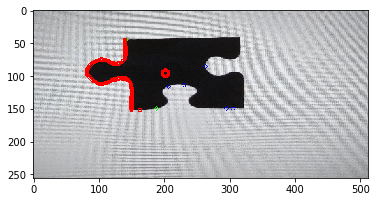

In [26]:
contour_list_left=[]
left_list =[]
img_left= img.copy()
#print(corners.ravel())
for c in contours:
    area = cv2.contourArea(c)
    
    if   (area  < 40000):
        for i in c:
            x,y = i.ravel()
            contour_list_left.append([x,y])
        #print(contour_list)
        for c in contour_list_left:
            pm = np.array([+1, -1])
            #print(c[0])
            #print(c[1])
            if (c[0] <= max(left_top_corner_point[0][0],left_bottom_corner_point[0][0]) and (left_top_corner_point[0][1] <= c[1] <= left_bottom_corner_point[0][1])):
                cv2.circle(img_left, tuple(c), 3 , (255,0,0), 1)
                left_list.append(c)
#print(left_list)
plt.imshow(img_left)
#print(left_list)

[[263, 86]]
[[295, 150]]


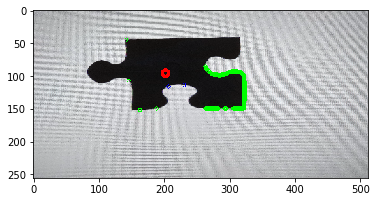

In [25]:
contour_list_right=[]
right_list =[]
img_right= img.copy()
#print(corners.ravel())
for c in contours:
    area = cv2.contourArea(c)
    
    if (area < 60000):
        for i in c:
            x,y = i.ravel()
            contour_list_right.append([x,y])
        #print(contour_list)
        for c in contour_list_right:
            #print(c[0])
            #print(c[1])
            if (c[0] >= min(right_top_corner_point[0][0],right_bottom_corner_point[0][0]) and (right_top_corner_point[0][1] <= c[1] <= right_bottom_corner_point[0][1])):
                cv2.circle(img_right, tuple(c), 3 , (0,255,0), 1)
                right_list.append(c)
#print(right_list)
plt.imshow(img_right)
print(right_top_corner_point)
print(right_bottom_corner_point)

In [20]:
print(len(contours))
#print(contours[5])
contour_5 =contours[4]
print(contour_5)

#print(contours.shape)

2


IndexError: list index out of range

In [ ]:
for contour in contours:
    contour_2 = contour.tolist()
print(contour_2)
print(contour_2[0][0])

In [ ]:
results_mod = [list(*x) for x in contour_2]
print(results_mod)

In [ ]:
b = rdp(contour_2, epsilon=0.5)
print(b)

In [ ]:
cnt = contours[4]
print(cnt)
print(cnt[0])
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
img_3 = cv2.drawContours(img,[box],0,(0,0,255),2)
print(box)
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img)
cv2.imshow("Mask", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
plt.imshow(img)
for i in cnt:
    img_2 = cv2.circle(img , (i[0][0],i[0][1]), 1 ,(255, 0 ,0),1)
plt.imshow(img_2)
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img_2)
#cv2.imshow("Mask", mask)
#key = cv2.waitKey(10000)
cv2.destroyAllWindows()


In [ ]:
#tile_center = ndimage.center_of_mass(mask)
#tile_center = tuple(np.round(tile_center).astype(np.int))
#print(tile_center)
#for contour in contours:
    #if contour[0] < tile_center[0] and 

In [ ]:
b = rdp(cnt, epsilon=1)
print(b.tolist())
for i in b:
    img_3 = cv2.circle(img , (i[0][0],i[0][1]), 1 ,(255, 0 ,0),1)
plt.imshow(img_3)
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img_3)
cv2.destroyAllWindows()

In [ ]:
contour_final =list()

for contour in contours[4]:
    area = cv2.contourArea(contour)
    #print(area)
    if   (area  > 40000 and area < 60000):
        #contour_final.append(contour)
        cv2.drawContours(img, contour, -1, (0, 255, 0), 3)

In [ ]:
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img)
cv2.imshow("Mask", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
plt.imshow(img)


In [ ]:
print(len(contour_final[0]))

In [ ]:
b = rdp(contour_final, epsilon=0.8)

In [ ]:
print(b)
print(len(b[0]))

In [ ]:
dst = dst * mask
data = dst.copy()
data[data < 0.1 * data.max()] = 0
datamax = filters.maximum_filter(data, 3)
maxima = (dst == datamax)
datamin = filters.minimum_filter(data, 3)
minima = (dst == datamin)
diff = ((datamax - datamin) > .01)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
# slices = ndimage.find_objects(labeled)
# yx = np.array(ndimage.center_of_mass(dst, labeled, range(1, num_objects+1)))
yx = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects + 1)))
temp = yx[:, 0].copy()
yx[:, 0] = yx[:, 1]
yx[:, 1] = temp
#print('7')
#print(np.round(yx).astype(np.int))
corners = np.round(yx).astype(np.int)
print(len(corners))
#print((corners))

for i in corners:
    img_4 = cv2.circle(img, tuple(i), 5, (0), 2)
cv2.namedWindow('corners_2', cv2.WINDOW_NORMAL)
cv2.imshow('corners_2', img_4 )
key = cv2.waitKey(10000)
cv2.destroyAllWindows()


In [ ]:
for c2 in corner_left_top_candidates:
        for c3 in corner_left_top_candidates:
            for c4 in corner_left_top_candidates:
                if not np.array_equal(c1,c2) and not np.array_equal(c1,c3) and not np.array_equal(c3,c2): 
                    if 90 - margin < get_angle(c1,c3,c2) < 90 + margin:
                        angle_candidates.append((c3,c4))
        #for j in corner_left_top_candidates_combination:
            
            #if 90 - margin < get_angle(i,j,k) < 90 + margin:
                    #angle_candidates.append([i ,j ,k])
    #print(angle_candidates)
    #
    print(angle_candidates)

In [ ]:
for i in corner_left_top_candidates_sorted:
        i = 0
        j = i+1
        k = j +1
        if 90 - margin < get_angle(corner_left_top_candidates_sorted[i], corner_left_top_candidates_sorted[j] ,corner_left_top_candidates_sorted[k]) < 90 + margin:
                        angle_candidates.append((corner_left_top_candidates_sorted[i], corner_left_top_candidates_sorted[j] ,corner_left_top_candidates_sorted[k]))
        i=i+1
    #print(angle_candidates)
    #corner_left_top_candidates_combination = list(combinations_with_replacement(corner_left_top_candidates, 2)) 
    #print(corner_left_top_candidates_combination)

In [ ]:
lower_ = np.array([30, 180, 60])
upper_ = np.array([120, 255, 255])
mask = cv2.inRange(hsv, lower_, upper_)
plt.imshow(mask)
cv2.namedWindow("Masked_Image" , cv2.WINDOW_NORMAL)
cv2.imshow("Masked_Image", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
#cv2.imshow("Masked_Image", mask)

In [ ]:
rect = cv2.minAreaRect(corners)
box = cv2.boxPoints(rect)
box = np.int0(box)
img_3 = cv2.drawContours(img,[box],0,(0,0,255),2)
print(box)
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img)
cv2.imshow("Mask", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
plt.imshow(img)

In [ ]:
path = "."
filename= [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
print(filename)

In [ ]:
lower_ = np.array([50, 180, 60])
upper_ = np.array([120, 255, 255])
mask = cv2.inRange(hsv, lower_, upper_)
plt.imshow(mask)
cv2.namedWindow("Masked_Image" , cv2.WINDOW_NORMAL)
cv2.imshow("Masked_Image", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
#cv2.imshow("Masked_Image", mask)

In [ ]:
#dst = cv2.cornerHarris(mask, 2, 3, 0.04)
    # Normalizing
#dst_norm = np.empty(dst.shape, dtype=np.float32)
#cv2.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
#dst_norm_scaled = cv2.convertScaleAbs(dst_norm)
# Drawing a circle around corners
#orner_points_j= []
#for i in range(dst_norm.shape[0]):
    #orner_points_i.append(j)
    #for j in range(dst_norm.shape[1]):
        #if int(dst_norm[i,j]) > 120:
            #corner_points_j.append(j)
            #cv2.circle(dst_norm_scaled, (j,i), 5, (0), 2)
            #rint(j)
            #rint(i)
            
            
# Showing the result
#cv2.namedWindow('corners', cv2.WINDOW_NORMAL)
#cv2.imshow('corners', dst_norm_scaled)
#plt.imshow(dst_norm_scaled)
#key = cv2.waitKey(10000)
#cv2.destroyAllWindows()

In [ ]:
tile_center1 = ndimage.center_of_mass(thresh)
print(tile_center1)
tile_center1 = tuple(np.round(tile_center1).astype(np.int))
print(tile_center1)

In [ ]:
def get_90deg_corners(pt, corners, rule1, rule2, margin = 20):
    """calculate all corners that are 90 degrees from pt, where the corners c1, c2 must comply with rule1, rule2 """
    #print(pt)
    res = []
    used = []
    #print('2')
    for c1 in corners:
        if not rule1(c1):
            continue
        #print('1')
        for c2 in corners:
            if np.array_equal(c1,c2) or np.array_equal(c2,pt) or np.array_equal(c1,pt) or \
                    not rule2(c2) or \
                    tuple(c2) in used:
                continue
            if 90 - margin < get_angle(c1,pt,c2) < 90 + margin:
                res.append((c1,c2))
                #print(res)
                used.append(tuple(c1))
    
    return res